In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch

In [3]:
from torch_geometric.data import Data, DataLoader
from torch_geometric.datasets import TUDataset, Planetoid
from torch_geometric.nn import GCNConv, Set2Set, GNNExplainer
import torch_geometric.transforms as T
import torch
import torch.nn.functional as F
import os

import matplotlib.pyplot as plt
from dgl.data import BACommunityDataset
import networkx as nx
import torch_geometric
import dgl


In [4]:
%cd C:\\Users\\Yurt\\Documents\\Cambridge\\GNN\\gnn_explainability

C:\Users\Yurt\Documents\Cambridge\GNN\gnn_explainability


In [37]:
from src.model import *
from src.data import *
from src.explainer import *
from src.plot import *
from src.modify import *
from src.protgnn import *

In [6]:
cora_dataset = get_cora_dataset()

In [7]:
ba_dataset = get_dataset("BAShapes")

Done loading data from cached files.


C:\Users\Yurt\anaconda3\lib\site-packages\torch_geometric\deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [8]:
num_classes = len(set([int(i) for i in ba_dataset.y]))
num_features = ba_dataset.x.shape[-1]

In [9]:
epochs = 200
dim = 16

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(num_features=num_features, dim=dim, num_classes=num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-3)


In [11]:
num_classes, num_features

(4, 1)

In [12]:
cora_dataset.x.shape

torch.Size([2708, 1433])

In [13]:
model = train_model(epochs,model,device,ba_dataset,optimizer,test_model)

[Train_loss:1.026566 Train_acc: 0.6661, Test_acc: 0.8643]: 100%|████████████████████| 200/200 [00:01<00:00, 183.05it/s]


In [14]:
num_classes = len(set([int(i) for i in cora_dataset.y]))
num_features = cora_dataset.x.shape[-1]

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(num_features=num_features, dim=dim, num_classes=num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-3)


In [16]:
model = train_model(epochs,model,device,cora_dataset,optimizer,test_model)

[Train_loss:1.610011 Train_acc: 0.4198, Test_acc: 0.4340]: 100%|█████████████████████| 200/200 [00:03<00:00, 66.45it/s]


In [17]:
explainer = GNNExplainer(model, epochs=200)

In [18]:
node_feature_mask, edge_mask = explain_model(explainer,cora_dataset,10)

Explain node 10: 100%|██████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 597.04it/s]


In [19]:
gce_explainer = GCExplainer()

In [20]:
gce_explainer.learn_prototypes(model,cora_dataset)

In [21]:
gce_explainer.get_prediction(model,cora_dataset)

array([0, 2, 0, ..., 1, 0, 0], dtype=int64)

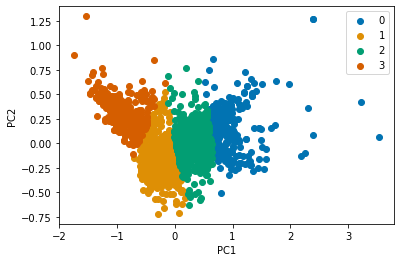

In [22]:
plot_kmeans_clusters(gce_explainer.kmeans,gce_explainer.initial_activations)

In [23]:
gce_explainer.get_prediction(model,identity(cora_dataset))

array([0, 2, 0, ..., 1, 0, 0], dtype=int64)

In [24]:
model = GCNNet_NC(num_features, num_classes, model_args)

In [25]:
cora_dataset.test_mask

tensor([False, False, False,  ...,  True,  True,  True])

In [26]:
model = train_model(epochs,model,device,cora_dataset,optimizer,test_model,protgnn=True)

[Train_loss:0.233402 Train_acc: 0.0738, Test_acc: 0.0660]: 100%|█████████████████████| 200/200 [00:37<00:00,  5.40it/s]


In [27]:
prot_explainer = ProtGNNExplainer()

In [28]:
prot_explainer.learn_prototypes(model,cora_dataset)

In [29]:
prot_explainer.get_prediction(model,cora_dataset)

array([13, 13, 13, ..., 13, 13, 13], dtype=int64)

In [30]:
model = GCN(num_features=num_features, dim=dim, num_classes=num_classes).to(device)

In [44]:
# register hooks to track activation
model = register_hooks(model)

In [45]:
train_model(epochs,model,device,cora_dataset,optimizer,test_model,if_interpretable_model=True)

Stats:   0%|                                                                                   | 0/200 [00:00<?, ?it/s]


TypeError: 'tuple' object is not callable

In [ ]:
cdm_explainer = CDMExplainer()

In [33]:
cdm_explainer.get_explanation(model, cora_dataset)
LAYER_KEY = "conv3"

NameError: name 'activation_list' is not defined

In [ ]:
concepts, _ = model(cora_dataset.x, cora_dataset.edge_index)
activation = torch.squeeze(activation_list[LAYER_KEY]).detach().numpy()

In [ ]:
# find centroids
centroids, centroid_labels, used_centroid_labels = find_centroids(activation, concepts, cora_dataset.y)
print(f"Number of cenroids: {len(centroids)}")

In [ ]:
DATASET_NAME = "BA_Shapes"
MODEL_NAME = f"GCN for {DATASET_NAME}"
LAYER_NUM = 3

seed = 42
path = os.path.join("..", "output", DATASET_NAME, f"seed_{seed}_v2")
# plot concept heatmaps
#plot_concept_heatmap(centroids, activation, cora_dataset.y, used_centroid_labels, MODEL_NAME, LAYER_NUM, path)

In [ ]:
from sklearn.metrics.cluster import homogeneity_score, completeness_score

# concept alignment
homogeneity = homogeneity_score(cora_dataset.y, used_centroid_labels)
# clustering efficency
completeness = completeness_score(cora_dataset.y, used_centroid_labels)

print(f"Concept homogeneity score: {homogeneity}")
print(f"Concept completeness score: {completeness}")

In [ ]:
# generate explanations
explanations = explain_classes(model, concepts, cora_dataset.y, cora_dataset.train_mask, cora_dataset.test_mask)

In [ ]:
def find_centroids(activation, concepts, y, tau=0.5):
    concepts = concepts.detach().numpy()
    centroids = []
    used_centroid_labels = np.zeros_like(y) - 1
    centroid_labels = []

    # gets boolean encoding of concepts
    cluster_general_labels = np.unique(concepts>tau, axis=0)

    for concept in range(len(cluster_general_labels)):
        # get all concept rows where have matching boolean encoding
        cluster_samples = np.where(((concepts>tau)==(cluster_general_labels[concept])).all(axis=1))[0]

        # take mean of those activations fitting the concept
        centroid = np.mean(activation[cluster_samples], axis=0)

        # sample - concept mapping
        used_centroid_labels[cluster_samples] = concept
        centroid_labels.append(concept)
        centroids.append(centroid)

    centroids = np.vstack(centroids)
    centroid_labels = np.stack(centroid_labels)

    return centroids, centroid_labels, used_centroid_labels

In [ ]:
from matplotlib import rc

def set_rc_params():
    small = 14
    medium = 20
    large = 28

    plt.rc('figure', autolayout=True, figsize=(12, 8))
    plt.rc('font', size=medium)
    plt.rc('axes', titlesize=medium, labelsize=small, grid=True)
    plt.rc('xtick', labelsize=small)
    plt.rc('ytick', labelsize=small)
    plt.rc('legend', fontsize=small)
    plt.rc('figure', titlesize=large, facecolor='white')
    plt.rc('legend', loc='upper left')

In [ ]:
# should be called with concepts
def plot_concept_heatmap(centroids, concepts, y, used_centroid_labels, model_name, layer_num, path, id_title="", id_path=""):
    LATEX_SYMBOL = ""  # Change to "$" if working out of server
    rc('text', usetex=(LATEX_SYMBOL == "$"))
    plt.style.use('seaborn-whitegrid')

    plt.figure(figsize=[15, 5])
    fig, ax = plt.subplots(len(np.unique(used_centroid_labels)), 2, gridspec_kw={'width_ratios': [5, 1]})
    # fig.set_size_inches(12, len(centroids) * 0.8)
    fig.suptitle(f"{id_title}Concept Heatmap of the {model_name} with concepts extracted from Layer {layer_num}")

    if torch.is_tensor(concepts):
        concepts = concepts.detach().numpy()
    else:
        concepts = concepts[:, np.newaxis]

    used_centroid_labels = used_centroid_labels.squeeze()

    nclasses = len(np.unique(y))
    if len(centroids) == 1:
        sns.heatmap(concepts[used_centroid_labels==0] > 0.5, cbar=None, ax=ax[0])
        sns.heatmap(y[used_centroid_labels==0].unsqueeze(-1), vmin=0, vmax=4, cmap="Set2", ax=ax[1])
    else:
        for i in range(len(np.unique(used_centroid_labels))):
            sns.heatmap(concepts[used_centroid_labels==i] > 0.5, cbar=None, ax=ax[i, 0],
                        xticklabels=False, yticklabels=False)
            sns.heatmap(y[used_centroid_labels==i].unsqueeze(-1), vmin=0, vmax=nclasses, cmap="Set2", ax=ax[i, 1],
                        xticklabels=False, yticklabels=False, cbar=None)

    legend_elements = [Patch(facecolor=c, label=f'Class {i // 2}') for i, c in
                       enumerate(sns.color_palette("Set2", 2 * nclasses)) if i % 2 == 0]
    fig.legend(handles=legend_elements, fontsize=18, loc='upper center', bbox_to_anchor=(0.5, 0.02),
               ncol=len(legend_elements))
    plt.savefig(os.path.join(path, f"{id_path}concept_heatmap_layer{layer_num}.png"))



In [ ]:
import torch_explain as te
from torch_explain.logic.nn import entropy
from torch_explain.logic.metrics import test_explanation, complexity
import torch.nn.functional as F

def explain_classes(model, concepts, y, train_mask, test_mask, max_minterm_complexity=1000, topk_explanations=1000, try_all=False):
    y = F.one_hot(y)
    y1h = F.one_hot(y[train_mask])
    y1h_test = F.one_hot(y[test_mask])

    explanations = {}

    for class_id in range(y1h.shape[1]):
        
        #explanation, _ = entropy.explain_class(model.lens, concepts.long().detach()[train_mask], y1h,
        #                                       concepts.long().detach()[train_mask], y1h, target_class=class_id,
        #                                       max_minterm_complexity=max_minterm_complexity,
        #                                       topk_explanations=topk_explanations, try_all=try_all)
        
        explanation, _ = entropy.explain_class(model.lens, concepts.long().detach(), y,
                                               train_mask, test_mask, target_class=class_id,
                                               max_minterm_complexity=max_minterm_complexity,
                                               topk_explanations=topk_explanations, try_all=try_all)

        print(explanation)
        #explanation_accuracy, _ = test_explanation(explanation, concepts[test_mask], y1h_test, target_class=class_id)
        print(len(y.shape))
        explanation_accuracy, _ = test_explanation(explanation, concepts, y, class_id, test_mask)
        explanation_complexity = complexity(explanation)

        explanations[str(class_id)] = {'explanation': explanation,
                                        'explanation_accuracy': explanation_accuracy,
                                        'explanation_complexity': explanation_complexity}

        print(f'Explanation class {class_id}: {explanation} - acc. = {explanation_accuracy:.4f} - compl. = {explanation_complexity:.4f}')

    return explanations